In [352]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.transformations.series.impute import Imputer
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from base.logging import Logger

In [4]:
PROJECT = 'covid'
ENV = 'dev'
ID = f'{PROJECT}-{ENV}'

global log
log = Logger(ID)

In [7]:
from base.data import Data

In [8]:
data = Data()
data.extract()
data.transform()
data.load()

/Users/tjordan/Documents/github/covid19/base/data.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df.index = pd.to_datetime(self.df.index)


In [385]:
class Forecast:
    def __init__(self,df):
        self.log = log
        self.df = df.rename({'ds':'Period'},axis=1).set_index('Period').loc[datetime.date(2020,5,1):]
        self.df.index = pd.to_datetime(self.df.index)
        self.df.index = pd.PeriodIndex(self.df.index,freq='D')
        self.df = self.df.y
        
        self.periods_fc = 90
        self.main_strt_dt = datetime.datetime(2022,8,1)
        self.test_strt_dt = (self.main_strt_dt - datetime.timedelta(days=self.periods_fc))
        
        self.test_model = None
        self.main_model = None
        
        self.test_fc = None
        self.main_fc = None

    def run(self,run_type):        
        if run_type == 'test':
            train_df = self.df.loc[:self.test_strt_dt]
            end_dt = self.test_strt_dt+datetime.timedelta(days=self.periods_fc)
            y = self.df.loc[self.test_strt_dt:end_dt]
        elif run_type == 'main':
            train_df = self.df.loc[:self.main_strt_dt]
            end_dt = self.main_strt_dt+datetime.timedelta(days=self.periods_fc)
            y = self.df.loc[self.main_strt_dt:end_dt]
        
        future = ForecastingHorizon(y.index, is_relative=False)
        model = ThetaForecaster(sp=12)
        # pipe = TransformedTargetForecaster(steps=[
        #     ("imputer", Imputer()),
        #     ("forecaster", NaiveForecaster())])
        # cv = ExpandingWindowSplitter(
        #     initial_window=24,
        #     step_length=12,
        #     fh=[1,2,3])
        # model = ForecastingGridSearchCV(
        #     forecaster=pipe,
        #     param_grid=[{
        #             "forecaster": [NaiveForecaster(sp=12)],
        #             "forecaster__strategy": ["drift", "last", "mean"],
        #         },
        #         {
        #             "imputer__method": ["mean", "drift"],
        #             "forecaster": [ThetaForecaster(sp=12)],
        #         },
        #         {
        #             "imputer__method": ["mean", "median"],
        #             "forecaster": [ExponentialSmoothing(sp=12)],
        #             "forecaster__trend": ["add", "mul"],
        #         },
        #     ],cv=cv,n_jobs=-1)
        model.fit(train_df)
        setattr(self,f'{run_type}_fc',pd.Series(model.predict(future),index=y.index,name='yhat'))
        setattr(self,f'{run_type}_model',model)
    
    def compile(self):
        self.fc = pd.concat([
            self.df.to_frame().loc[:self.test_strt_dt],
            self.test_fc.to_frame().merge(self.df.to_frame(),how='inner',left_index=True,right_index=True),
            self.main_fc.to_frame(),
        ],axis=0).reset_index(drop=False)
        self.fc['ds'] = pd.to_datetime(self.fc.Period.dt.strftime('%Y-%m-%d'))
    
    def eval(self):
        self.mape = mean_absolute_percentage_error(self.fc.y,self.fc.yhat)
    
    def graph(self):
        plt.style.use('fivethirtyeight') # ggplot, fivethirtyeight, tableau-colorblind10, grayscale

        fig, ax1 = plt.subplots(figsize=(12,6))
        fig.suptitle('Covid19 Time Series Forecast - Richmond, VA', fontsize=18) # fontweight='bold'
        fig.tight_layout()
        ax1.grid(True)

        ax1.plot(self.fc.ds,self.fc.y,color='#091d63',label='Y',linewidth=2)
        ax1.plot(self.fc.ds,self.fc.yhat,color='#630909',linestyle='--',label='Yhat',linewidth=2)
        # ax1.plot(self.fc.ds,self.fc.yhat_lower,color='#000000',linestyle=':',label='Yhat Lower',linewidth=2)
        # ax1.plot(self.fc.ds,self.fc.yhat_upper,color='#000000',linestyle=':',label='Yhat Upper',linewidth=2)
        ax1.set_xlabel('Date',fontsize=10)
        ax1.set_ylabel('Covid19 Cases',fontsize=10)
        ax1.legend(loc='upper left')
        
        ax1.xaxis.set_tick_params(rotation=45)
        # ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.figtext(0,-0.2,f'Data up to {self.main_strt_dt.strftime("%Y-%m-%d")}',fontsize=10)

In [386]:
fc = Forecast(data.df)

In [387]:
fc.run('test')
fc.run('main')
fc.compile()

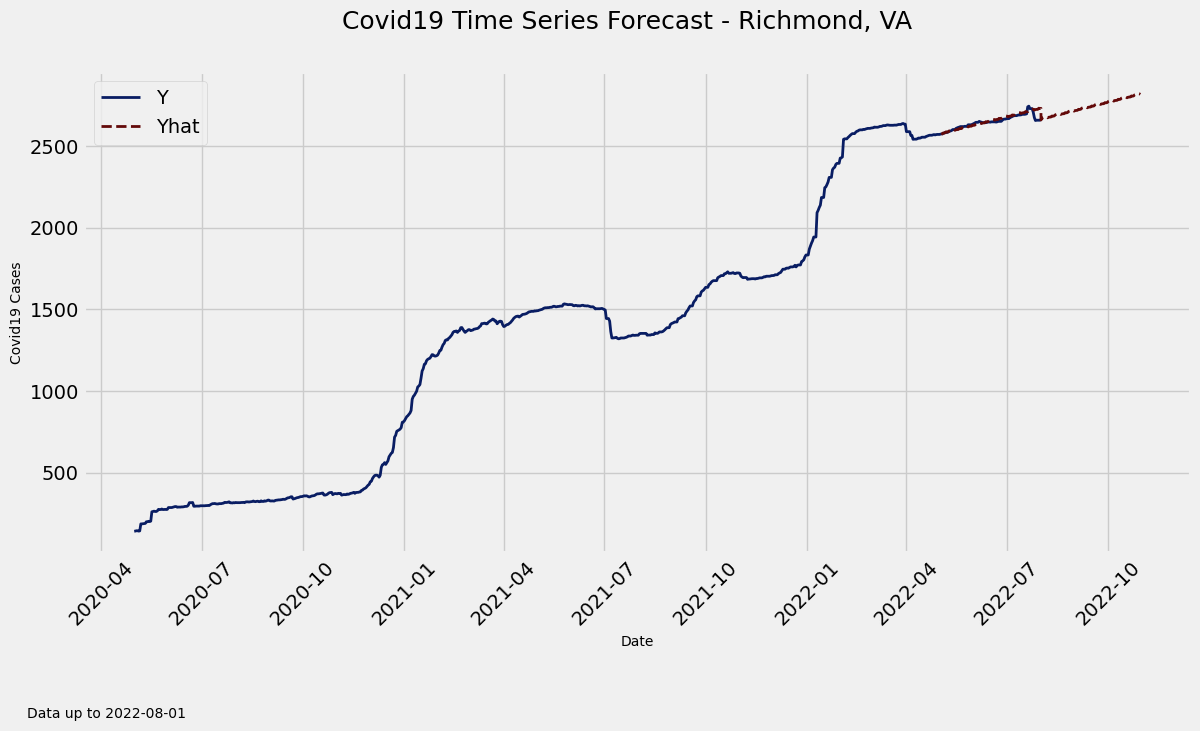

In [388]:
fc.graph()